# Analyse des activations des neurones de diff√©rents mod√®les

L'objectif de ce notebook est d'observer si il existe des similarit√©s entre les activations de diff√©rents mod√®les.

Pour cela on dispose d'un jeu de donn√©es cr√©er √† partir de centaines de mod√®les avec exactement les m√™mes hyperparam√®tres.
Ces mod√®les on √©t√© entra√Æn√© sur le jeux de donn√©es MNIST, et ont tous d'excellente performance. Pour chaque mod√®les on dispose de 10 donn√©es d'activations une pour la pr√©diction de chaque chiffre.

In [35]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
import warnings

## Configuration

In [2]:
# chemin vers le fichier csv contenant le jeu de donn√©es
mm_file = "../../data/activations/multi_mlp.csv"

# Cette variable indique les nombres de neuronnes et le nombre de couche cach√© 
# elle doit correspondre √† celle utilis√© pour cr√©er le jeux de donn√©es
hidden_sizes = [128, 64] 

In [3]:
activations = pd.read_csv(mm_file)
activations_reduced = activations.drop(columns=["nb_true", "nb_pred"])

accuracy = accuracy_score(activations["nb_true"], activations["nb_pred"])
nb_model = int(activations.shape[0] / 10)
print(f"Pr√©cision moyenne des {nb_model} mod√®les : {accuracy:.2f}")

Pr√©cision moyenne des 276 mod√®les : 0.96


## Premi√®re analyse

On commence par afficher une image avec les activations de tous les mod√®les pour pr√©dire un z√©ro pour voir si l'on observe des paternes √©vident. On s'attend tout de m√™me √† ne rien observer dutout.

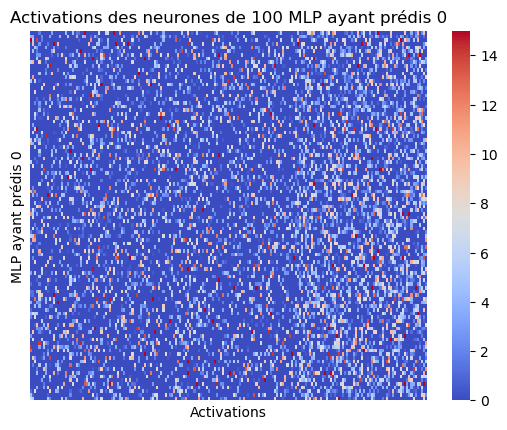

In [21]:
zero_activations = activations_reduced[activations["nb_pred"] == 0].head(100)
sns.heatmap(zero_activations, cmap="coolwarm", vmax=15, xticklabels=False, yticklabels=False)
plt.xlabel("Activations")
plt.ylabel("MLP ayant pr√©dis 0")
plt.title("Activations des neurones de 100 MLP ayant pr√©dis 0")
plt.show()

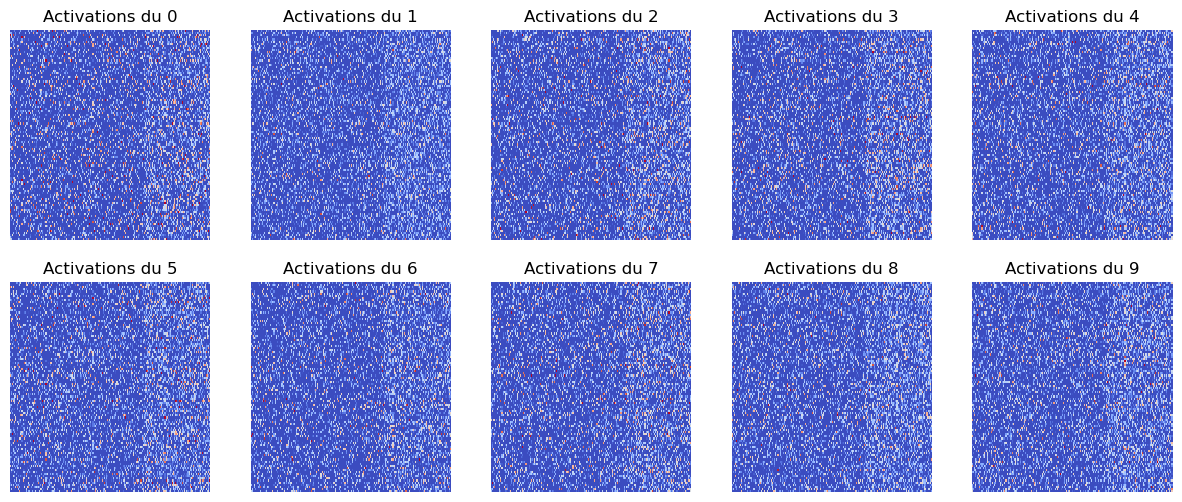

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    sns.heatmap(
            activations_reduced[activations["nb_pred"] == i].head(100),
            cmap="coolwarm",cbar=False , vmax=15, ax=ax
            )
    ax.set_title(f"Activations du {i}")  
    ax.axis("off") 
plt.show()

In [32]:
print(np.mean(activations_reduced.iloc[:,:128].to_numpy().flatten()))
print(np.mean(activations_reduced.iloc[:,129:].to_numpy().flatten()))

1.2830899103431612
2.0586823087392436


On observe effectivement que entre mod√®les on ne semble observer aucune similitude √©vidente.
On va √©galement essayer de faire une analyse en composante principales.

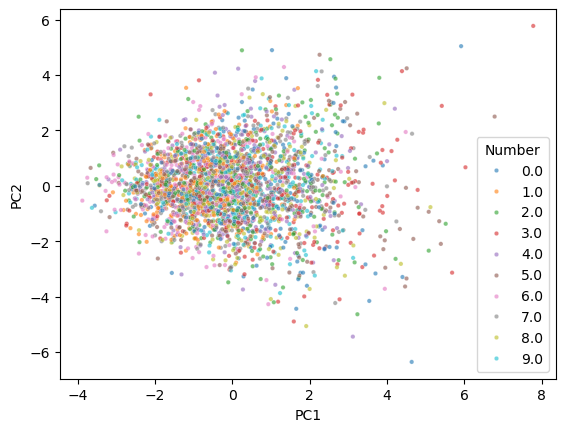

In [5]:
def plot_acp(data, labels):
    # on commence par normaliser les donn√©es 
    data_normalized = StandardScaler().fit_transform(data)

    # ensuite on effectue l'ACP avec 2 composantes
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_normalized)

    # transforme les r√©sultats en dataframe 
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Number'] = labels

    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Number',
        palette='tab10',  # Palette de 10 couleurs
        data=pca_df,
        s=10, alpha=0.6  # R√©duire la taille des points pour plus de clart√©
    )
    plt.show()

plot_acp(activations_reduced, activations["nb_true"])

On observe aussi avec l'ACP que pour diff√©rent mod√®les il ne semble y avoir aucune similitude dans les activations.

## Mod√®les XGboost

Maintenant on va mettre en place un mod√®le xgboost qui aura pour objectif de pr√©dire le nombre qui a √©t√© pr√©dit en fonction des activations.

Pr√©cision du mod√®le : 0.11


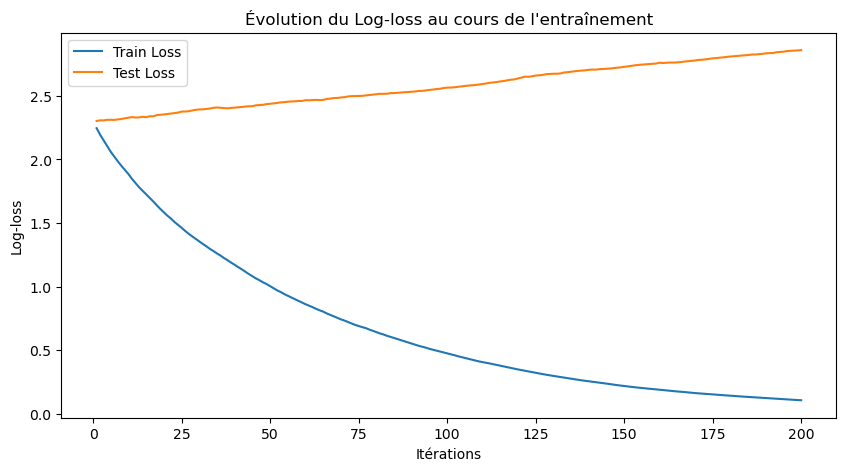

In [6]:
y = activations["nb_pred"]
X_train, X_test, y_train, y_test = train_test_split(activations_reduced, y, test_size=0.2, shuffle=True)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softmax",  # Probl√®me de classification multiclasses
    "num_class": 10,               # Nombre de classes
    "max_depth": 3,               # Profondeur maximale des arbres
    "eta": 0.3,                   # Taux d'apprentissage (learning rate)
    "eval_metric": "mlogloss"     # Log-loss pour √©valuer le mod√®le
}

num_round = 200
evals = [(dtrain, "train"), (dtest, "eval")]
evals_result = {}

# Entra√Ænement du mod√®le avec suivi des performances
bst = xgb.train(params, dtrain, num_round, evals=evals, evals_result=evals_result, verbose_eval=False)

# Pr√©dictions
preds = bst.predict(dtest)
accuracy = accuracy_score(y_test, preds)
print(f"Pr√©cision du mod√®le : {accuracy:.2f}")

# üìà Visualisation de l'√©volution du log-loss
epochs = range(1, num_round + 1)
train_loss = evals_result["train"]["mlogloss"]
test_loss = evals_result["eval"]["mlogloss"]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.xlabel("It√©rations")
plt.ylabel("Log-loss")
plt.title("√âvolution du Log-loss au cours de l'entra√Ænement")
plt.legend()
plt.show()

In [36]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f"Pr√©cision du Random Forest: {accuracy_score(y_test, y_pred)}")

Pr√©cision du Random Forest: 0.11594202898550725


Pr√©cision finale du mod√®le : 0.09


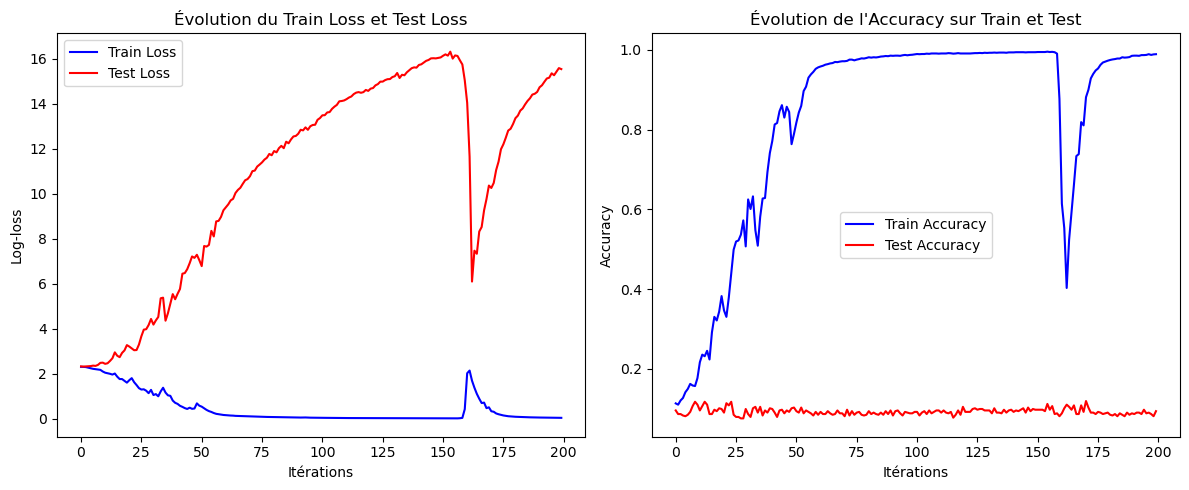

In [39]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),  # 2 couches cach√©es (64 et 32 neurones)
                    activation="relu",            # Fonction d'activation ReLU
                    solver="adam",                # Optimiseur Adam
                    learning_rate_init=0.005,      # Taux d'apprentissage
                    max_iter=200,                 # Nombre d'it√©rations
                    random_state=42)

# Initialisation des variables pour stocker les pertes et accuracies
train_loss = []
test_loss = []
train_acc = []
test_acc = []

# Entra√Ænement manuel avec suivi des pertes et accuracy
for i in range(1, mlp.max_iter + 1):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y))  # Entra√Ænement incr√©mental
    
    # Pr√©dictions probabilistes
    train_pred_proba = mlp.predict_proba(X_train)
    test_pred_proba = mlp.predict_proba(X_test)
    
    # Calcul du log-loss sur train et test
    train_loss.append(log_loss(y_train, train_pred_proba))
    test_loss.append(log_loss(y_test, test_pred_proba))
    
    # Pr√©dictions finales (classes) pour calculer l'accuracy
    train_pred = mlp.predict(X_train)
    test_pred = mlp.predict(X_test)
    
    train_acc.append(accuracy_score(y_train, train_pred))
    test_acc.append(accuracy_score(y_test, test_pred))

# Pr√©cision finale du mod√®le
print(f"Pr√©cision finale du mod√®le : {test_acc[-1]:.2f}")

# üìà Visualisation des pertes et accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graphique des pertes (Log-loss)
axes[0].plot(train_loss, label="Train Loss", color='blue')
axes[0].plot(test_loss, label="Test Loss", color='red')
axes[0].set_xlabel("It√©rations")
axes[0].set_ylabel("Log-loss")
axes[0].set_title("√âvolution du Train Loss et Test Loss")
axes[0].legend()

# Graphique de l'accuracy
axes[1].plot(train_acc, label="Train Accuracy", color='blue')
axes[1].plot(test_acc, label="Test Accuracy", color='red')
axes[1].set_xlabel("It√©rations")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("√âvolution de l'Accuracy sur Train et Test")
axes[1].legend()

plt.tight_layout()
plt.show()

In [8]:
def evaluate_logistic(X, y) -> float:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=100)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

In [33]:
evaluate_logistic(activations_reduced, activations["nb_pred"])

0.09420289855072464

In [12]:
svd1 = TruncatedSVD(n_components=128-1)
svd2 = TruncatedSVD(n_components=64-1)
svd3 = TruncatedSVD(n_components=128+64-1)

svd1.fit(activations_reduced.iloc[:,:128])
svd2.fit(activations_reduced.iloc[:,129:])
svd3.fit(activations_reduced)

variance_cumulee1 = np.cumsum(svd1.explained_variance_ratio_)
variance_cumulee2 = np.cumsum(svd2.explained_variance_ratio_)
variance_cumulee3 = np.cumsum(svd3.explained_variance_ratio_)

variance_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

n_comps = {"first":[], "second":[], "mixed":[]}

for variance in variance_list:
    n_comps["first"].append(np.searchsorted(variance_cumulee1, variance) + 1)
    n_comps["second"].append(np.searchsorted(variance_cumulee2, variance) + 1)
    n_comps["mixed"].append(np.searchsorted(variance_cumulee3, variance) + 1)

In [13]:
warnings.filterwarnings("ignore", category=UserWarning)
accs = {"mixed":[], "first":[], "second":[]}

for i in range(len(variance_list)):
    svd1 = TruncatedSVD(n_components=n_comps["first"][i])
    svd2 = TruncatedSVD(n_components=n_comps["second"][i])
    svd3 = TruncatedSVD(n_components=n_comps["mixed"][i])


    first_layer = svd1.fit_transform(activations_reduced.iloc[:,:128])
    second_layer = svd2.fit_transform(activations_reduced.iloc[:,129:])
    mixed_layer = svd3.fit_transform(activations_reduced)

    accs["mixed"].append(evaluate_logistic(mixed_layer, activations["nb_pred"]))
    accs["first"].append(evaluate_logistic(first_layer, activations["nb_pred"]))
    accs["second"].append(evaluate_logistic(second_layer, activations["nb_pred"]))

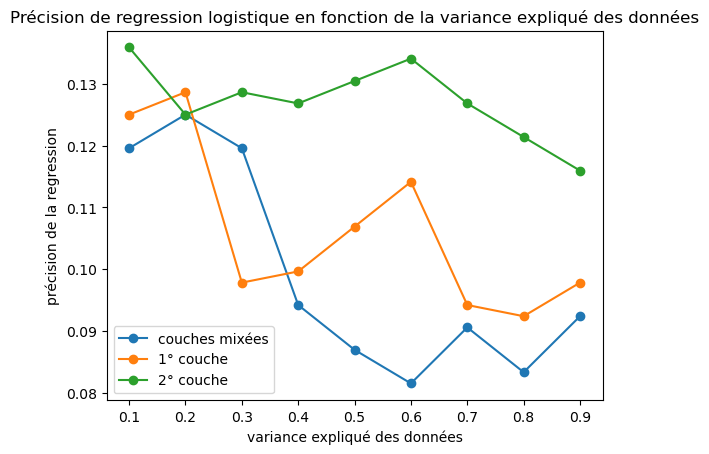

In [14]:
plt.plot(variance_list, accs["mixed"], marker='o', linestyle='-', label="couches mix√©es")
plt.plot(variance_list, accs["first"], marker='o', linestyle='-', label="1¬∞ couche")
plt.plot(variance_list, accs["second"], marker='o', linestyle='-', label="2¬∞ couche")
plt.xlabel("variance expliqu√© des donn√©es")
plt.ylabel("pr√©cision de la regression")
plt.xticks(variance_list)
plt.legend()
plt.title("Pr√©cision de regression logistique en fonction de la variance expliqu√© des donn√©es")
plt.show()